# Intermediate deep learning with pytorch

## Chapter 1 - Training Robust Neural Networks

### Section 1.2 - PyTorch and object-oriented programming

#### PyTorch Dataset
Time to refresh your PyTorch Datasets knowledge!

Before model training can commence, you need to load the data and pass it to the model in the right format. In PyTorch, this is handled by Datasets and DataLoaders. Let's start with building a PyTorch Dataset for our water potability data.

In this exercise, you will define a class called WaterDataset to load the data from a CSV file. To do this, you will need to implement the three methods which PyTorch expects a Dataset to have:

- `.__init__()` to load the data,
- `.__len__()` to return data size,
- `.__getitem()__` to extract features and label for a single sample.
The following imports that you need have already been done for you:

`import pandas as pd
from torch.utils.data import Dataset`

In [ ]:
import torch

# Check if GPU is available
print(torch.cuda.is_available())

In [ ]:
from torch.utils.data import Dataset
import pandas as pd

class WaterDataset(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        # Load data to pandas DataFrame
        df = pd.read_csv(csv_path)
        # Convert data to a NumPy array and assign to self.data
        self.data = df.to_numpy()
        
    # Implement __len__ to return the number of data samples
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        features = torch.tensor(self.data[idx, :-1]).float()
        # Assign last data column to label
        label = torch.tensor(self.data[idx,-1]).float()
        return features, label

#### PyTorch DataLoader
Good job defining the Dataset class! The `WaterDataset` you just created is now available for you to use.

The next step in preparing the training data is to set up a `DataLoader`. A PyTorch `DataLoader` can be created from a `Dataset` to load data, split it into batches, and perform transformations on the data if desired. Then, it yields a data sample ready for training.

In this exercise, you will build a `DataLoader` based on the `WaterDataset`. The `DataLoader` class you will need has already been imported for you from `torch.utils.data`. Let's get to it!

In [ ]:
from torch.utils.data import DataLoader
import torch

# Create an instance of the WaterDataset
dataset_train = WaterDataset("water_potability.csv")

# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(
    dataset_train,
    batch_size=2,
    shuffle=False,
)

# Get a batch of features and labels
features, labels = next(iter(dataloader_train))
print(features, labels)

#### PyTorch Model
You will use the OOP approach to define the model architecture. Recall that this requires setting up a model class and defining two methods inside it:

- `.__init__()`, in which you define the layers you want to use;

- `forward()`, in which you define what happens to the model inputs once it receives them; this is where you pass inputs through pre-defined layers.

Let's build a model with three linear layers and ReLU activations. After the last linear layer, you need a sigmoid activation instead, which is well-suited for binary classification tasks like our water potability prediction problem. Here's the model defined using nn.Sequential(), which you may be more familiar with:

```
net = nn.Sequential(
  nn.Linear(9, 16),
  nn.ReLU(),
  nn.Linear(16, 8),
  nn.ReLU(),
  nn.Linear(8, 1),
  nn.Sigmoid(),
)
```

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the three linear layers
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8,1)
        
    def forward(self, x):
        # Pass x through linear layers adding activations
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x

#### Optimizers
It's time to explore the different optimizers that you can use for training your model.

A custom function called `train_model(optimizer, net, num_epochs)` has been defined for you. It takes the optimizer, the model, and the number of epochs as inputs, runs the training loops, and prints the training loss at the end.

Let's use `train_model()` to run a few short trainings with different optimizers and compare the results!

In [ ]:
def train_model(optimizer, net, num_epochs):
    criterion = nn.BCELoss()
    for epoch in range(num_epochs):
        running_loss = 0.
        for features, labels in dataloader_train:
            optimizer.zero_grad()
            outputs = net(features)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    train_loss = running_loss / len(dataloader_train)
    print(f"Training loss after {num_epochs} epochs: {train_loss}")

In [ ]:
import torch.optim as optim

net = Net()

# Define the SGD optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001)

train_model(
    optimizer=optimizer,
    net=net,
    num_epochs=10,
)

In [ ]:
import torch.optim as optim

net = Net()

# Define the RMSprop optimizer
optimizer = optim.RMSprop(net.parameters(), lr=0.001)

train_model(
    optimizer=optimizer,
    net=net,
    num_epochs=10,
)

In [ ]:
import torch.optim as optim

net = Net()

# Define the Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_model(
    optimizer=optimizer,
    net=net,
    num_epochs=10,
)

#### Model evaluation
With the training loop sorted out, you have trained the model for 1000 epochs, and it is available to you as `net`. You have also set up a `test_dataloader` in exactly the same way as you did with `train_dataloader` before—just reading the data from the test rather than the train directory.

You can now evaluate the model on test data. To do this, you will need to write the evaluation loop to iterate over the batches of test data, get the model's predictions for each batch, and calculate the accuracy score for it. Let's do it!

**Intermezzo** - create test and train loader. The train the model.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.init as init

def train_model(optimizer, net, num_epochs):
    criterion = nn.BCELoss()
    for epoch in range(num_epochs):
        running_loss = 0.
        for features, labels in dataloader_train:
            optimizer.zero_grad()
            outputs = net(features)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    train_loss = running_loss / len(dataloader_train)
    print(f"Training loss after {num_epochs} epochs: {train_loss}")

dataset = pd.read_csv("water_potability.csv")
train_dataset = dataset.sample(frac=0.8)
train_dataset.to_csv("water_potability_train.csv", index=False)
test_dataset = dataset.drop(index=train_dataset.index)
test_dataset.to_csv("water_potability_test.csv", index=False)

# create a train and test loader
batch_size = 32
train_pytorch_dataset = WaterDataset("water_potability_train.csv")
dataloader_train = DataLoader(train_pytorch_dataset, batch_size=batch_size, shuffle=True)

test_pytorch_dataset = WaterDataset("water_potability_test.csv")
dataloader_test = DataLoader(test_pytorch_dataset, batch_size=batch_size, shuffle=False)

net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.005)

train_model(optimizer=optimizer, net=net, num_epochs=200)

**the exercise**

In [ ]:
import torch
from torchmetrics import Accuracy

# Set up binary accuracy metric
acc = Accuracy(task='binary')

net.eval()
with torch.no_grad():
    for features, labels in dataloader_test:
        # Get predicted probabilities for test data batch
        outputs = net(features)
        preds = (outputs >= 0.5).float()
        acc(preds, labels.view(-1,1))

# Compute total test accuracy
test_accuracy = acc.compute()
print(f"Test accuracy: {test_accuracy*100:.2f}%")

### Section 1.3 - Vanashing and exploding gradients

#### Initialization and activation
The problems of unstable (vanishing or exploding) gradients are a challenge that often arises in training deep neural networks. In this and the following exercises, you will expand the model architecture that you built for the water potability classification task to make it more immune to those problems.

As a first step, you'll improve the weights initialization by using He (Kaiming) initialization strategy. To do so, you will need to call the proper initializer from the `torch.nn.init` module, which has been imported for you as `init`. Next, you will update the activations functions from the default ReLU to the often better ELU.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        
        # Apply He initialization
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")

    def forward(self, x):
        # Update ReLU activation to ELU
        x = nn.functional.elu(self.fc1(x))
        x = nn.functional.elu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x

#### Batch Normalization

As a final improvement to the model architecture, let's add the batch normalization layer after each of the two linear layers. The batch norm trick tends to accelerate training convergence and protects the model from vanishing and exploding gradients issues.

Both torch.nn and torch.nn.init have already been imported for you as nn and init, respectively. Once you implement the change in the model architecture, be ready to answer a short question on how batch normalization works!

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 16)
        # Add two batch normalization layers
        self.bn1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.fc3 = nn.Linear(8, 1)
        
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)

        # Pass x through the second set of layers
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.elu(x)

        x = nn.functional.sigmoid(self.fc3(x))
        return x

## Chapter 2 - Images & Convolutional Neural Networks

Download the data from

https://www.kaggle.com/competitions/cloud-type-classification2/data

it is not include in the repository.

### Section 2.1 - Handling Images with PyTorch

#### Intermezzo - prepare data for pytorch image datasets

We need a script that takes the source data and puts all pictures of one class in one folder For this the `train.csv` crucial.

we go through each row in the file, create a directory for the class if it does not exist and then copy the file in this directory.

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import shutil
from tqdm.notebook import tqdm

def prepare_dataset_for_pytorch(input_csv: str, input_dir: str, output_dir: str):
    """
    Organizes images into class-labeled directories for PyTorch training.
    """
    df = pd.read_csv(input_csv)
    output_dir_path = Path(output_dir)

    # iterate over each row with tqdm for progress display
    for row in tqdm(df.itertuples(index=False), total=len(df), desc="Copying files"):
        # Extract file name and label
        filename = row.id
        label = row.label

        # create input path based on input dir
        input_file_path = Path(input_dir) / filename

        # skip missing files
        # using the continue - it will skip the rest of the for loop iteration 
        if not input_file_path.exists():
            print(f"Warning: Missing file {input_file_path}")
            continue

        # create a path that includes the label and create 
        # directory if necessary
        class_dir = output_dir_path / str(label)
        class_dir.mkdir(parents=True, exist_ok=True)

        # create a file path to save the image
        output_file_path = class_dir / filename

        # copy the file to the new location
        shutil.copy(src=input_file_path, dst=output_file_path)

output_train_dir = "./cloud-type-classification2/train_data"
input_train_dir = "./cloud-type-classification2/images/train/"
input_csv = "./cloud-type-classification2/train.csv"

prepare_dataset_for_pytorch(input_csv, input_train_dir, output_train_dir)


Copying files:   0%|          | 0/960 [00:00<?, ?it/s]

#### Image dataset
Let's start with building a Torch Dataset of images. You'll use it to explore the data and, later, to feed it into a model.

The training data for the cloud classification task is stored in the following directory structure:

```
clouds_train
  - cirriform clouds
    - 539cd1c356e9c14749988a12fdf6c515.jpg
    - ...
  - clear sky
  - cumulonimbus clouds
  - cumulus clouds
  - high cumuliform clouds
  - stratiform clouds
  - stratocumulus clouds
```

There are seven folders inside clouds_train, each representing one cloud type (or a clear sky). Inside each of these folders sit corresponding image files.

The following imports have already been done for you:
```
from torchvision.datasets import ImageFolder
from torchvision import transforms
```

In [10]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [12]:
# Compose transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

# Create Dataset using ImageFolder
dataset_train = ImageFolder(
    "cloud-type-classification2/train_data/",
    transform=train_transforms,
)

In [25]:
img, idx = dataset_train[200]

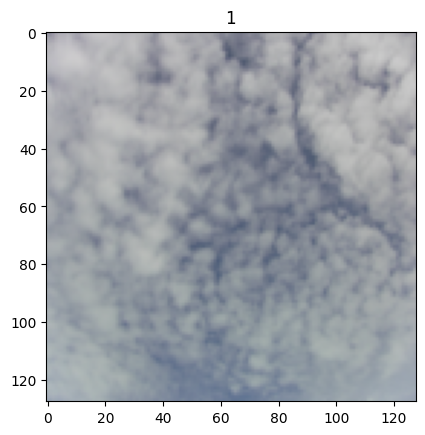

In [26]:
plt.imshow(img.permute(1,2,0))
plt.title(idx)
plt.show()

#### Data augmentation in PyTorch
Let's include data augmentation in your Dataset and inspect some images visually to make sure the desired transformations are applied.

First, you'll add the augmenting transformations to `train_transforms`. Let's use a random horizontal flip and a rotation by a random angle between 0 and 45 degrees. The code that follows to create the Dataset and the DataLoader is exactly the same as before. Finally, you'll reshape the image and display it to see if the new augmenting transformations are visible.

All the imports you need have been called for you:

```
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
```

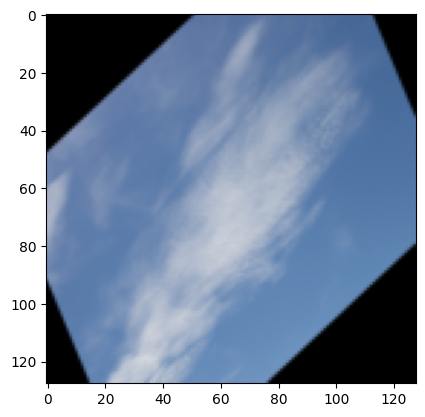

In [30]:
from torch.utils.data import DataLoader

train_transforms = transforms.Compose([
    # Add horizontal flip and rotation
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

dataset_train = ImageFolder(
  "cloud-type-classification2/train_data/",
  transform=train_transforms,
)

dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=1
)

image, label = next(iter(dataloader_train))
# Reshape the image tensor
image = image.squeeze().permute(1, 2, 0) 
# Display the image
plt.imshow(image)
plt.show()

### 2.2 - Convolutional Neural Networks

#### Building convolutional networks
You are on a team building a weather forecasting system. As part of the system, cameras will be installed at various locations to take pictures of the sky. Your task is to build a model to classify different cloud types in these pictures, which will help spot approaching weather fronts.

You decide to build a convolutional image classifier. The model will consist of two parts:

- A feature extractor that learns a vector of features from the input image,
- A classifier that predicts the image's class based on the learned features.

Both torch and torch.nn as nn have already been imported for you, so let's get to it!

**remark** - pytorch assumes an input [B, channels, width, height]

In [80]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            # Flatten (B, C, W, H) -> (B, C x W x H) here (B, 64 x 32 x 32)
            nn.Flatten(),
        )
        # Define classifier
        self.classifier = nn.Linear(64 * 32 * 32, num_classes)
    
    def forward(self, x):  
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [87]:
# create the network
net = Net(num_classes=7)

batch_img = img.unsqueeze(dim=0)
print(batch_img.shape)

print(net(batch_img).shape)

torch.Size([1, 3, 128, 128])
torch.Size([1, 7])


### Section 2.3 - Train image classifier

#### Dataset with augmentations
You have already built the image dataset from cloud pictures and the convolutional model to classify different cloud types. Before you train it, let's adapt the dataset by adding the augmentations that could improve the model's cloud classification performance.

The code to set up the Dataset and DataLoader is already prepared for you and should look familiar. Your task is to define the composition of transforms that will be applied to the input images as they are loaded.

Note that before you were resizing images to 128 by 128 to display them nicely, but now you will use smaller ones to speed up training. As you will see later, 64 by 64 will be large enough for the model to learn.

`from torchvision import transforms`
has been already executed for you, so let's get to it!

In [91]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

dataset_train = ImageFolder(
  "./cloud-type-classification2/train_data/",
  transform=train_transforms,
)
dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=16
)

len(dataloader_train)

60

#### Image classifier training loop
It's time to train the image classifier! You will use the Net you defined earlier and train it to distinguish between seven cloud types.

To define the loss and optimizer, you will need to use functions from torch.nn and torch.optim, imported for you as nn and optim, respectively. You don't need to change anything in the training loop itself: it's exactly like the ones you wrote before, with some additional logic to print the loss during training.

In [92]:
import torch.nn as nn
import torch.optim as optim

# Define the model
net = Net(num_classes=7)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 2.1572
Epoch 2, Loss: 1.3815
Epoch 3, Loss: 1.2394


In [97]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# Define the model
net = Net(num_classes=7).cuda()  # Ensure it's on GPU
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    net.train()
    running_loss = 0.0
    loop = tqdm(dataloader_train, desc=f"Epoch {epoch+1}", leave=True)

    for i, (images, labels) in enumerate(loop):
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss = running_loss / (i + 1)

        # Update tqdm with current and average loss
        loop.set_postfix(batch_loss=loss.item(), avg_loss=avg_loss)

    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")



poch 1: 100%|██████████████████████████████████████████| 60/60 [03:27<00:00,  3.46s/it, avg_loss=2.16, batch_loss=1.37]

Epoch 1 completed. Average Loss: 2.1550



poch 2: 100%|██████████████████████████████████████████| 60/60 [03:32<00:00,  3.54s/it, avg_loss=1.37, batch_loss=1.11]

Epoch 2 completed. Average Loss: 1.3732


Epoch 3: 100%|███████████████████████████████████████████| 60/60 [03:36<00:00,  3.61s/it, avg_loss=1.26, batch_loss=1.7]

Epoch 3 completed. Average Loss: 1.2557


In [100]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = Net(num_classes=7).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    net.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    loop = tqdm(dataloader_train, desc=f"Epoch {epoch+1}", leave=True)

    for i, (images, labels) in enumerate(loop):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_samples += images.size(0)

        batch_loss = loss.item()
        batch_acc = torch.sum(preds == labels).item() / images.size(0)

        loop.set_postfix(batch_loss=f"{batch_loss:.4f}", batch_acc=f"{batch_acc:.4f}")

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    print(f"Epoch {epoch+1} completed. Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")



poch 1: 100%|█████████████████████████████████████| 60/60 [02:55<00:00,  2.93s/it, batch_acc=0.3750, batch_loss=1.9974]

Epoch 1 completed. Loss: 2.1899, Accuracy: 0.3094



poch 2: 100%|█████████████████████████████████████| 60/60 [02:54<00:00,  2.90s/it, batch_acc=0.4375, batch_loss=1.7512]

Epoch 2 completed. Loss: 1.4648, Accuracy: 0.4313


Epoch 3: 100%|█████████████████████████████████████| 60/60 [03:58<00:00,  3.97s/it, batch_acc=0.6250, batch_loss=1.1923]

Epoch 3 completed. Loss: 1.3683, Accuracy: 0.4479


### Section 2.4 - Evaluting image classifiers

#### Multi-class model evaluation
Let's evaluate our cloud classifier with precision and recall to see how well it can classify the seven cloud types. In this multi-class classification task it is important how you average the scores over classes. Recall that there are four approaches:
- Not averaging, and analyzing the results per class;
- Micro-averaging, ignoring the classes and computing the metrics globally;
- Macro-averaging, computing metrics per class and averaging them;
- Weighted-averaging, just like macro but with the average weighted by class size.

Both `Precision` and `Recall` are already imported from torchmetrics. It's time to see how well our model is doing!

**remark** - I did not split the train data in train and test. So the train dataloader is used to test performance. This should not be done in practice!!!

In [101]:
from torchmetrics import Precision, Recall
from tqdm import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define metrics
metric_precision = Precision(task="multiclass", num_classes=7, average="micro").to(device)
metric_recall = Recall(task="multiclass", num_classes=7, average="micro").to(device)

net.eval()
with torch.no_grad():
    loop = tqdm(dataloader_train, desc="Evaluating", leave=True)
    
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, preds = torch.max(outputs, 1)

        metric_precision.update(preds, labels)
        metric_recall.update(preds, labels)

        loop.set_postfix(batch_size=images.size(0))

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Evaluating: 100%|████████████████████████████████████████████████████████| 60/60 [04:20<00:00,  4.34s/it, batch_size=16]

Precision: 0.5333
Recall: 0.5333


#### Analyzing metrics per class
While aggregated metrics are useful indicators of the model's performance, it is often informative to look at the metrics per class. This could reveal classes for which the model underperforms.

In this exercise, you will run the evaluation loop again to get our cloud classifier's precision, but this time per-class. Then, you will map these score to the class names to interpret them. As usual, Precision has already been imported for you. Good luck!

In [106]:
# Define precision metric
metric_precision = Precision(
    task="multiclass", num_classes=7, average=None
).to(device)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_train:
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
precision = metric_precision.compute()

# Get precision per class
precision_per_class = {
    k: precision[v].item()
    for k, v 
    in dataset_train.class_to_idx.items()
}
print(precision_per_class)

{'0': 0.5416666865348816, '1': 0.6987179517745972, '2': 0.3909091055393219, '3': 0.49462366104125977, '4': 0.9230769276618958, '5': 0.5465116500854492, '6': 0.594936728477478}


## Chapter 3 - Sequences & Recurrent Neural Networks

### Section 3.1 - Handling sequences with PyTorch

#### Generating sequences
To be able to train neural networks on sequential data, you need to pre-process it first. You'll chunk the data into inputs-target pairs, where the inputs are some number of consecutive data points and the target is the next data point.

Your task is to define a function to do this called create_sequences(). As inputs, it will receive data stored in a DataFrame, df and seq_length, the length of the inputs. As outputs, it should return two NumPy arrays, one with input sequences and the other one with the corresponding targets.

As a reminder, here is how the DataFrame df looks like:
```
                timestamp  consumption
0      2011-01-01 00:15:00    -0.704319
...                    ...          ...
140255 2015-01-01 00:00:00
```


In [107]:
import numpy as np

def create_sequences(df, seq_length):
    xs, ys = [], []
    # Iterate over data indices
    for i in range(len(df) - seq_length):
      	# Define inputs
        x = df.iloc[i:(i + seq_length), 1]
        # Define target
        y = df.iloc[i + seq_length, 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

#### Sequential Dataset
Good job building the `create_sequences()` function! It's time to use it to create a training dataset for your model.

Just like tabular and image data, sequential data is easiest passed to a model through a torch Dataset and DataLoader. To build a sequential Dataset, you will call `create_sequences()` to get the NumPy arrays with inputs and targets, and inspect their shape. Next, you will pass them to a `TensorDataset` to create a proper torch Dataset, and inspect its length.

Your implementation of `create_sequences()` and a DataFrame with the training data called `train_data` are available.

In [111]:
import pandas as pd

train_data = pd.read_csv("electricity_consump/electricity_train.csv")
train_data.shape

(105215, 2)

In [117]:
import torch
from torch.utils.data import TensorDataset

# Use create_sequences to create inputs and targets
X_train, y_train = create_sequences(train_data, 24 * 4)
print(X_train.shape, y_train.shape)

# Create TensorDataset
dataset_train = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float(),
)
print(len(dataset_train))

(105119, 96) (105119,)
105119


In [118]:
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

In [131]:
import torch
from torch.utils.data import TensorDataset
import pandas as pd

test_data = pd.read_csv("electricity_consump/electricity_test.csv")
print(test_data.shape)

# Use create_sequences to create inputs and targets
X_test, y_test = create_sequences(test_data, 24 * 4)
print(X_test.shape, y_test.shape)

# Create TensorDataset
dataset_test = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).float(),
)
print(len(dataset_test))

dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

(35040, 2)
(34944, 96) (34944,)
34944


#### Building a forecasting RNN

It's time to build your first recurrent network! It will be a sequence-to-vector model consisting of an RNN layer with two layers and a hidden_size of 32. After the RNN layer, a simple linear layer will map the outputs to a single value to be predicted.

The following imports have already been done for you:

```
import torch
import torch.nn as nn
```

In [113]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define RNN layer
        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        # Initialize first hidden state with zeros
        h0 = torch.zeros(2, x.size(0), 32)
        # Pass x and h0 through recurrent layer
        out, _ = self.rnn(x, h0)  
        # Pass recurrent layer's last output through linear layer
        out = self.fc(out[:, -1, :])
        return out

### Section 3.3 - LSTM and GRU cells

#### LSTM network
As you already know, plain RNN cells are not used that much in practice. A more frequently used alternative that ensures a much better handling of long sequences are Long Short-Term Memory cells, or LSTMs. In this exercise, you will be build an LSTM network yourself!

The most important implementation difference from the RNN network you have built previously comes from the fact that LSTMs have two rather than one hidden states. This means you will need to initialize this additional hidden state and pass it to the LSTM cell.

`torch` and `torch.nn` have already been imported for you, so start coding!

In [114]:
class Net(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # Define lstm layer
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        # Initialize long-term memory
        c0 = torch.zeros(2, x.size(0), 32)
        # Pass all inputs to lstm layer
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out[:, -1, :])
        return out

#### GRU network

Next to LSTMs, another popular recurrent neural network variant is the Gated Recurrent Unit, or GRU. It's appeal is in its simplicity: GRU cells require less computation than LSTM cells while often matching them in performance.

The code you are provided with is the RNN model definition that you coded previously. Your task is to adapt it such that it produces a GRU network instead. `torch` and `torch.nn` as nn have already been imported for you.

In [115]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define RNN layer
        self.gru = nn.GRU(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.gru(x, h0)  
        out = self.fc(out[:, -1, :])
        return out

### Section 3.4 - Training and evaluating RNNs

#### RNN training loop
It's time to train the electricity consumption forecasting model!

You will use the LSTM network you have defined previously, which has been instantiated and assigned to net, as is the `dataloader_train` you built before. You will also need to use `torch.nn` which has already been imported as `nn`.

In this exercise, you will train the model for only three epochs to make sure the training progresses as expected. Let's get to it!

In [129]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

for epoch in range(3):
    running_loss = 0.0
    pbar = tqdm(dataloader_train, desc=f"Epoch {epoch+1}")
    
    for seqs, labels in pbar:
        # Reshape inputs
        seqs = seqs.view(seqs.size(0), 96, 1)
        labels = labels.view(-1, 1)  # Ensure shape (B, 1)
        
        outputs = net(seqs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")



poch 1: 100%|███████████████████████████████████████████████████████████| 3285/3285 [03:07<00:00, 17.53it/s, loss=0.18]

Epoch 1, Loss: 0.1502



poch 2: 100%|████████████████████████████████████████████████████████| 3285/3285 [03:13<00:00, 16.94it/s, loss=0.00817]

Epoch 2, Loss: 0.0588


Epoch 3: 100%|██████████████████████████████████████████████████████████| 3285/3285 [03:16<00:00, 16.72it/s, loss=0.206]

Epoch 3, Loss: 0.0575


#### Evaluating forecasting models

It's evaluation time! The same LSTM network that you have trained in the previous exercise has been trained for you for a few more epochs and is available as `net`.

Your task is to evaluate it on a test dataset using the Mean Squared Error metric (`torchmetrics` has already been imported for you). Let's see how well the model is doing!

In [134]:
from torchmetrics import MeanSquaredError

# Define MSE metric
mse = torchmetrics.MeanSquaredError()

net.eval()
with torch.no_grad():
    for seqs, labels in dataloader_test:
        seqs = seqs.view(32, 96, 1)
        # Pass seqs to net and squeeze the result
        outputs = net(seqs).squeeze()
        mse(outputs, labels)

# Compute final metric value
test_mse = mse.compute()
print(f"Test MSE: {test_mse}")

NameError: name 'torchmetrics' is not defined